In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load Predictions

In [68]:
# Load predictions 
net_import_df = pd.read_csv('Predictions/import_export.csv', index_col = 0)
solar_pred = pd.read_csv('Predictions/solar_pred.csv', index_col = 0)
wind_pred = pd.read_csv('Predictions/wind_pred.csv', index_col = 0)

In [69]:
net_import_df.columns = ['year', 'month', 'day', 'hour', 'net import']
solar_pred.columns = ['year', 'month', 'day', 'hour', 'solar']
wind_pred.columns = ['year', 'month', 'day', 'hour', 'wind']

In [70]:
net_import_df = net_import_df.set_index(['year', 'month', 'day', 'hour'])
solar_pred = solar_pred.set_index(['year', 'month', 'day', 'hour'])
wind_pred = wind_pred.set_index(['year', 'month', 'day', 'hour'])

In [71]:
# Combine predictions 
combined = net_import_df.merge(solar_pred, how='inner', left_index=True, right_index=True)
combined = combined.merge(wind_pred, how='inner', left_index=True, right_index=True)

In [72]:
combined = combined.reset_index()
combined = combined.sort_values(by=['year', 'month', 'day', 'hour'])
combined =combined.set_index(['year', 'month', 'day', 'hour'])

### PJM Historical Load Forecasts
From https://dataminer2.pjm.com/feed/load_frcstd_hist

In [211]:
# PJM Load Forecasts
pjm_df = pd.concat(map(pd.read_csv, ['load_forecasts/pjm/2016.csv', 'load_forecasts/pjm/2017.csv','load_forecasts/pjm/2018.csv']))
pjm_df = pjm_df.drop(['evaluated_at_utc', 'evaluated_at_ept', 'forecast_hour_beginning_ept'], axis = 1)
pjm_df.columns = ['Date', 'area', 'PJM']

In [212]:
pjm_df

,Date,area,PJM
0,1/1/2016 5:00:00 AM,AEP,14043.0
1,1/1/2016 5:00:00 AM,APS,5686.0
2,1/1/2016 5:00:00 AM,COMED,10669.0
3,1/1/2016 5:00:00 AM,DAY,1776.0
4,1/1/2016 5:00:00 AM,DOM,9032.0
...,...,...,...
754566,1/1/2019 4:00:00 AM,DEOK,2416.0
754567,1/1/2019 4:00:00 AM,DOM,9001.0
754568,1/1/2019 4:00:00 AM,MIDATL,26982.0
754569,1/1/2019 4:00:00 AM,DUQ,1296.0


In [236]:
# There are multiple forecasts provided per area per hour so average them first 
pjm_df = pjm_df.groupby( ['Date', 'area'] ).mean().reset_index()

In [237]:
# Then final total load per hour
pjm_df = pjm_df.groupby( ['Date'] ).sum().reset_index()

In [238]:
pjm_df['Date'] = pd.to_datetime(pjm_df['Date'])

In [239]:
def extract_date(df, date_col):
    df.copy(deep=True)
    df['hour'] = df[date_col].dt.hour
    df['month'] = df[date_col].dt.month
    df['year'] = df[date_col].dt.year
    df['day'] = df[date_col].dt.dayofyear
    return df 

In [240]:
pjm_df = extract_date(pjm_df, 'Date') 

In [241]:
pjm_df = pjm_df.sort_values(by=['year', 'month', 'day', 'hour'])
pjm_df = pjm_df.set_index(['year', 'month', 'day', 'hour'])

In [242]:
pjm_df = pjm_df.drop(['Date'], axis = 1)

### Baseline: Compare PJM's Load Forecasts to Actual Generation

In [230]:
actual_gen = actual_gen.drop(['datetime_beginning_ept', 'fuel_type', 'fuel_percentage_of_total', 'is_renewable'], axis = 1)
actual_gen = actual_gen.groupby( ['datetime_beginning_utc'] ).sum().reset_index()
actual_gen['datetime_beginning_utc'] = pd.to_datetime(actual_gen['datetime_beginning_utc'])

actual_gen = extract_date(actual_gen, 'datetime_beginning_utc')
actual_gen = actual_gen.drop(['datetime_beginning_utc'], axis=1)
actual_gen = actual_gen.set_index(['year', 'month', 'day', 'hour'])

In [244]:
# Graph against PJM DF 
actual_gen = actual_gen.merge(pjm_df, how='inner', left_index=True, right_index=True)

actual_gen

mw            PJM
year month day hour                         
2018 5     140 8      68030.0  121770.666667
     9     273 15     78098.9  149195.000000
     6     180 10     89035.8  174241.333333
     9     256 13     99914.2  195863.714286
     6     165 2     103850.8  197172.800000
...                       ...            ...
     9     254 4      80339.3  151562.000000
     8     234 16    110889.7  219760.000000
     12    338 3      94001.7  178359.600000
     11    312 19     86524.2  172150.250000
     8     219 8      95321.1  173654.000000

[5858 rows x 2 columns]

In [181]:
actual = actual_gen[['mw']]
predicted = actual_gen[['PJM']]

actual['count'] = np.arange(len(actual))
predicted['count'] = np.arange(len(predicted))

In [190]:
actual_100 = actual.head(200)
predicted_100 = predicted.head(200)

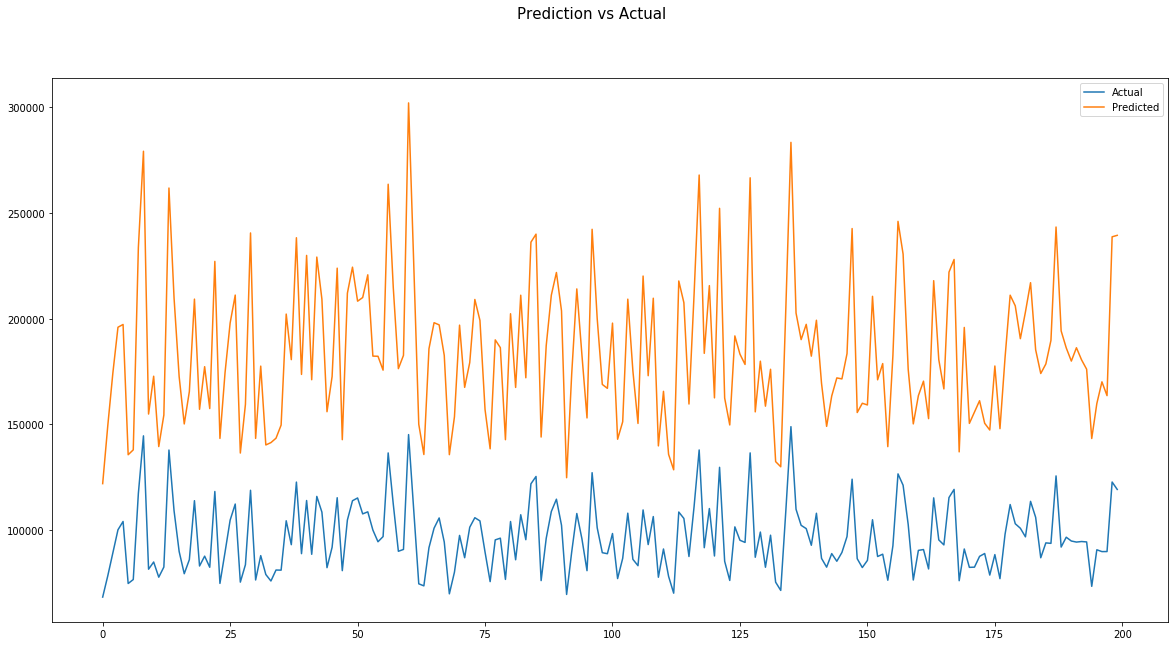

In [191]:
plt.figure(figsize=(20,10))
plt.suptitle('Prediction vs Actual', fontsize=15)
plt.plot(actual_100['count'], actual_100['mw'], label='Actual')
plt.plot(predicted_100['count'], predicted_100['PJM'], label='Predicted')
plt.legend()

Is the difference because of imports / exports? 

In [245]:
df = pd.concat(map(pd.read_csv, ['import_exports/2016.csv', 'import_exports/2017.csv','import_exports/2018.csv']))

# just look at actual flow for now
df = df.drop(['datetime_ending_utc', 'datetime_ending_ept', 'inadv_flow', 'sched_flow'], axis=1)

isorto_df = df.groupby(['datetime_beginning_utc'] ).sum().reset_index()

In [246]:
isorto_df.datetime_beginning_utc = pd.to_datetime(isorto_df['datetime_beginning_utc'])  

In [247]:
isorto_df = extract_date(isorto_df, 'datetime_beginning_utc')
isorto_df = isorto_df.drop(['datetime_beginning_utc'], axis=1)
isorto_df = isorto_df.set_index(['year', 'month', 'day', 'hour'])

In [248]:
import_included = actual_gen.merge(isorto_df, how='inner', left_index=True, right_index=True)

import_included

mw            PJM  actual_flow
year month day hour                                      
2018 5     140 8      68030.0  121770.666667    -2720.064
     9     273 15     78098.9  149195.000000    -5630.207
     6     180 10     89035.8  174241.333333    -1906.015
     9     256 13     99914.2  195863.714286    -2669.815
     6     165 2     103850.8  197172.800000    -1458.407
...                       ...            ...          ...
     9     254 4      80339.3  151562.000000    -2808.684
     8     234 16    110889.7  219760.000000    -2092.295
     12    338 3      94001.7  178359.600000    -2662.608
     11    312 19     86524.2  172150.250000     -658.412
     8     219 8      95321.1  173654.000000    -4862.734

[5858 rows x 3 columns]

In [249]:
import_included['with_import'] = import_included['mw'] + import_included['actual_flow']

In [250]:
import_included

mw            PJM  actual_flow  with_import
year month day hour                                                   
2018 5     140 8      68030.0  121770.666667    -2720.064    65309.936
     9     273 15     78098.9  149195.000000    -5630.207    72468.693
     6     180 10     89035.8  174241.333333    -1906.015    87129.785
     9     256 13     99914.2  195863.714286    -2669.815    97244.385
     6     165 2     103850.8  197172.800000    -1458.407   102392.393
...                       ...            ...          ...          ...
     9     254 4      80339.3  151562.000000    -2808.684    77530.616
     8     234 16    110889.7  219760.000000    -2092.295   108797.405
     12    338 3      94001.7  178359.600000    -2662.608    91339.092
     11    312 19     86524.2  172150.250000     -658.412    85865.788
     8     219 8      95321.1  173654.000000    -4862.734    90458.366

[5858 rows x 4 columns]

/home/amy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/amy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


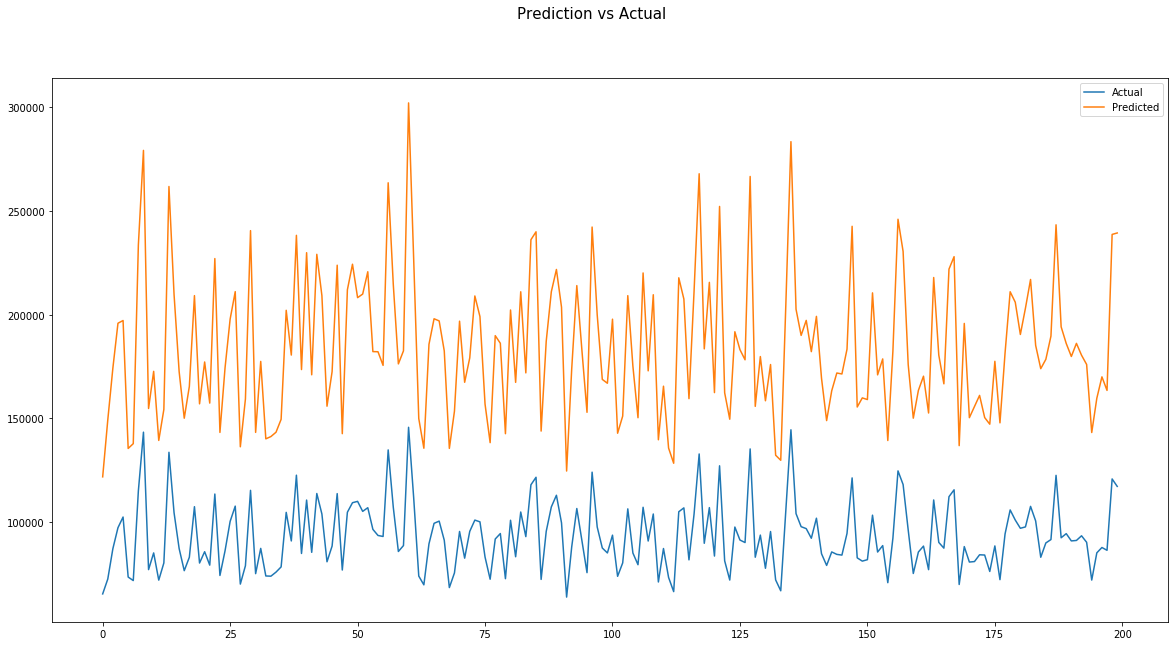

In [252]:
actual = import_included[['with_import']]
predicted = import_included[['PJM']]

actual['count'] = np.arange(len(actual))
predicted['count'] = np.arange(len(predicted))

actual_100 = actual.head(200)
predicted_100 = predicted.head(200)

plt.figure(figsize=(20,10))
plt.suptitle('Prediction vs Actual', fontsize=15)
plt.plot(actual_100['count'], actual_100['with_import'], label='Actual')
plt.plot(predicted_100['count'], predicted_100['PJM'], label='Predicted')
plt.legend()

### Get Fossil Generation

In [192]:
fossil_gen = combined.merge(pjm_df, how='inner', left_index=True, right_index=True)

In [193]:
# Add net import with PJM 
fossil_gen['fossil gen'] = fossil_gen['PJM'] + fossil_gen['net import']

In [194]:
# Subtract solar and wind 
fossil_gen['fossil gen'] = fossil_gen['fossil gen'] - fossil_gen['solar'] - fossil_gen['wind']

In [195]:
fossil_gen =  fossil_gen[['fossil gen']]

### Compare with actual fossil generation 

In [229]:
actual_gen = pd.read_csv('actual_gen.csv')

In [178]:
# There are the following fuel types at each hour 
actual_gen.fuel_type.unique()

array(['Coal', 'Gas', 'Hydro', 'Multiple Fuels', 'Nuclear', 'Oil',
       'Other', 'Other Renewables', 'Solar', 'Storage', 'Wind'],
      dtype=object)

### Compare to Fossil Generation (Coal, Gas, Multiple Fuels, Oil)

In [197]:
fossil_fuel_type = ['Coal', 'Gas', 'Multiple Fuels', 'Oil']
actual_gen = actual_gen.loc[actual_gen['fuel_type'].isin(fossil_fuel_type)]

In [198]:
actual_gen = actual_gen.drop(['datetime_beginning_ept', 'fuel_type', 'fuel_percentage_of_total', 'is_renewable'], axis = 1)
actual_gen = actual_gen.groupby( ['datetime_beginning_utc'] ).sum().reset_index()
actual_gen['datetime_beginning_utc'] = pd.to_datetime(actual_gen['datetime_beginning_utc'])


In [199]:
def extract_date(df, date_col):
    df.copy(deep=True)
    df['hour'] = df[date_col].dt.hour
    df['month'] = df[date_col].dt.month
    df['year'] = df[date_col].dt.year
    df['day'] = df[date_col].dt.dayofyear
    return df 

In [200]:
actual_gen = extract_date(actual_gen, 'datetime_beginning_utc')
actual_gen = actual_gen.drop(['datetime_beginning_utc'], axis=1)
actual_gen = actual_gen.set_index(['year', 'month', 'day', 'hour'])

In [201]:
actual_gen = actual_gen.merge(fossil_gen, how='inner', left_index=True, right_index=True)

actual = actual_gen[['mw']]
predicted = actual_gen[['fossil gen']]

actual['count'] = np.arange(len(actual))
predicted['count'] = np.arange(len(predicted))

actual_100 = actual.head(100)
predicted_100 = predicted.head(100)

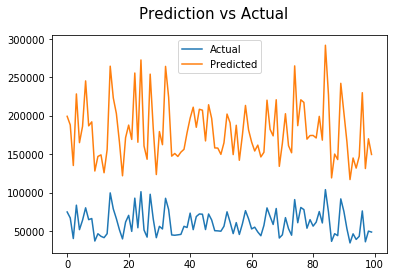

In [202]:
plt.suptitle('Prediction vs Actual', fontsize=15)
plt.plot(actual_100['count'], actual_100['mw'], label='Actual')
plt.plot(predicted_100['count'], predicted_100['fossil gen'], label='Predicted')
plt.legend()

### Compare to All Generation Except Solar and Wind 

In [205]:
actual_gen = actual_gen.loc[~actual_gen['fuel_type'].isin(['Wind', 'Solar'])]

In [206]:
actual_gen = actual_gen.drop(['datetime_beginning_ept', 'fuel_type', 'fuel_percentage_of_total', 'is_renewable'], axis = 1)
actual_gen = actual_gen.groupby( ['datetime_beginning_utc'] ).sum().reset_index()
actual_gen['datetime_beginning_utc'] = pd.to_datetime(actual_gen['datetime_beginning_utc'])


In [207]:
actual_gen = extract_date(actual_gen, 'datetime_beginning_utc')
actual_gen = actual_gen.drop(['datetime_beginning_utc'], axis=1)
actual_gen = actual_gen.set_index(['year', 'month', 'day', 'hour'])

In [208]:
actual_gen = actual_gen.merge(fossil_gen, how='inner', left_index=True, right_index=True)

actual = actual_gen[['mw']]
predicted = actual_gen[['fossil gen']]

actual['count'] = np.arange(len(actual))
predicted['count'] = np.arange(len(predicted))

actual_100 = actual.head(100)
predicted_100 = predicted.head(100)

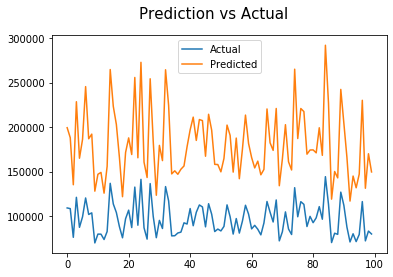

In [209]:
plt.suptitle('Prediction vs Actual', fontsize=15)
plt.plot(actual_100['count'], actual_100['mw'], label='Actual')
plt.plot(predicted_100['count'], predicted_100['fossil gen'], label='Predicted')
plt.legend()